In [1]:
import json
import numpy as np
from pathlib import Path
import time
start_time = time.time()
import sys, os, contextlib
import matplotlib.pyplot as plt

import xobjects as xo
import xtrack as xt
import xcoll as xc
import xpart as xp

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


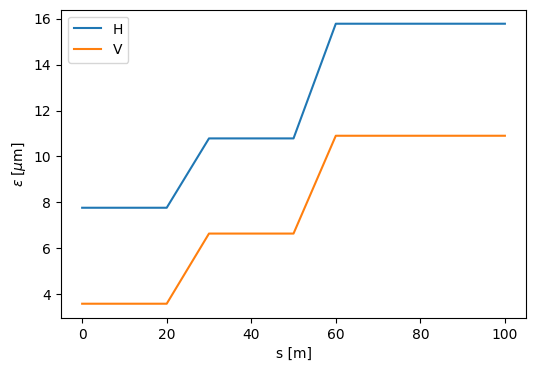

In [2]:
num_part = int(5000)


# Make a transfer line
# ====================
k_qf_1 = 0.32730047
k_qd_2 = -0.36102915
k_qf_3 = 0.32789126
k_qd_4 = -0.1991137
l_quad = 2

elements = [
            xt.Quadrupole(k1=k_qf_1, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_2, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qf_3, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_4, length=l_quad),
            xt.Drift(length=89.),
            xt.Marker(),
            xt.Multipole(length=1.0, knl=[0.0])
           ]
element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                 "drift_4", "END", "fake_multipole"]
particle_ref = xp.Particles(energy0=24.e9)
line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

# Add air regions
# ===============
X0_air = 301
air = xc.Material(radiation_length=X0_air, name="Air (1 atm 20C)")

line.insert_element(element=xc.EverestBlock(length=10, material=air), name="Air 1", at_s=20)
line.insert_element(element=xc.EverestBlock(length=10, material=air), name="Air 2", at_s=50)


# Add monitors
# ============
mon_air_1_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_1_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
line.insert_element(element=mon_air_1_s, name="monitor air 1 start", at_s=20)
line.insert_element(element=mon_air_1_e, name="monitor air 1 end", at_s=30)
line.insert_element(element=mon_air_2_s, name="monitor air 2 start", at_s=50)
line.insert_element(element=mon_air_2_e, name="monitor air 2 end", at_s=60)

# Generate an initial distribution of particles
# =============================================
line.build_tracker()

# Scattering need to be disabled to be able to twiss
line["Air 1"]._tracking = False
line["Air 2"]._tracking = False

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
dx0 = 0.13
dy0 = 0.0
dpx0 = 0.02
dpy0 = 0.0
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)

nemitt_x = 7.639770207283603e-06
nemitt_y = 3.534081877201574e-06
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()

# re-enable scattering
line["Air 1"]._tracking = True
line["Air 2"]._tracking = True



# Track and store emittance at every turn
# =======================================
def calculate_nemitt(part):
    cov_x = np.cov(part.x, part.px)
    cov_y = np.cov(part.y, part.py)
    nemitt_x = part.gamma0[0]*np.sqrt(cov_x[0,0]*cov_x[1,1]-cov_x[1,0]*cov_x[0,1])
    nemitt_y = part.gamma0[0]*np.sqrt(cov_y[0,0]*cov_y[1,1]-cov_y[1,0]*cov_y[0,1])
    return nemitt_x, nemitt_y

def calculate_nemitt_monitor(mon):
    result = []
    for turn in range(mon.x.shape[1]):
        cov_x = np.cov([x[turn] for x in mon.x], [px[turn] for px in mon.px])
        cov_y = np.cov([y[turn] for y in mon.y], [py[turn] for py in mon.py])
        nemitt_x = part.gamma0[0]*np.sqrt(cov_x[0,0]*cov_x[1,1]-cov_x[1,0]*cov_x[0,1])
        nemitt_y = part.gamma0[0]*np.sqrt(cov_y[0,0]*cov_y[1,1]-cov_y[1,0]*cov_y[0,1])
        result = [*result, [nemitt_x, nemitt_y]]
    return result

ex, ey = calculate_nemitt(part)
nemitt_x = [ex]
nemitt_y = [ey]

 # Track the particles
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

ex, ey = calculate_nemitt_monitor(mon_air_1_s)[0]
nemitt_x.append(ex)
nemitt_y.append(ey)
ex, ey = calculate_nemitt_monitor(mon_air_1_e)[0]
nemitt_x.append(ex)
nemitt_y.append(ey)
ex, ey = calculate_nemitt_monitor(mon_air_2_s)[0]
nemitt_x.append(ex)
nemitt_y.append(ey)
ex, ey = calculate_nemitt_monitor(mon_air_2_e)[0]
nemitt_x.append(ex)
nemitt_y.append(ey)
ex, ey = calculate_nemitt(part)
nemitt_x.append(ex)
nemitt_y.append(ey)


# Plot the result
# ===============
_, ax = plt.subplots(figsize=(6,4))
s = [0, 20, 30, 50, 60, 100]
ax.plot(s, 1.e6*np.array(nemitt_x), label='H')
ax.plot(s, 1.e6*np.array(nemitt_y), label='V')
ax.set_ylabel(r"$\epsilon\; [\mu\mathrm{m}]$")
ax.set_xlabel("s [m]")
ax.legend()


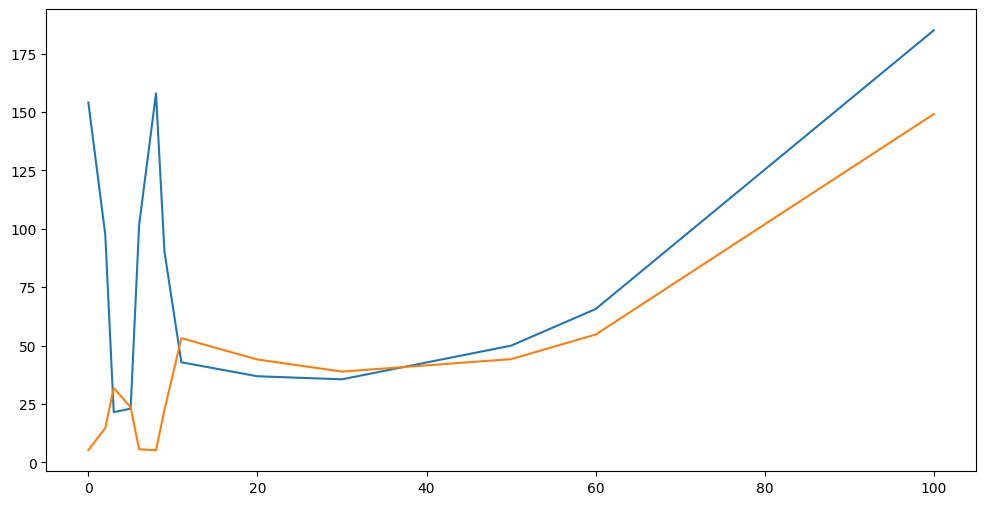

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tw.s, tw.betx)
ax.plot(tw.s, tw.bety)

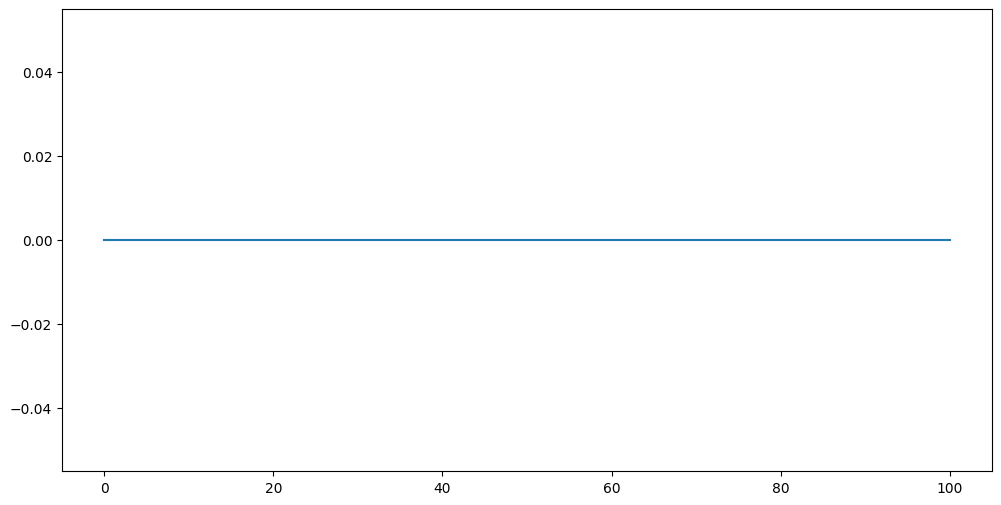

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tw.s, tw.delta)

Text(0, 0.5, 'y [m]')

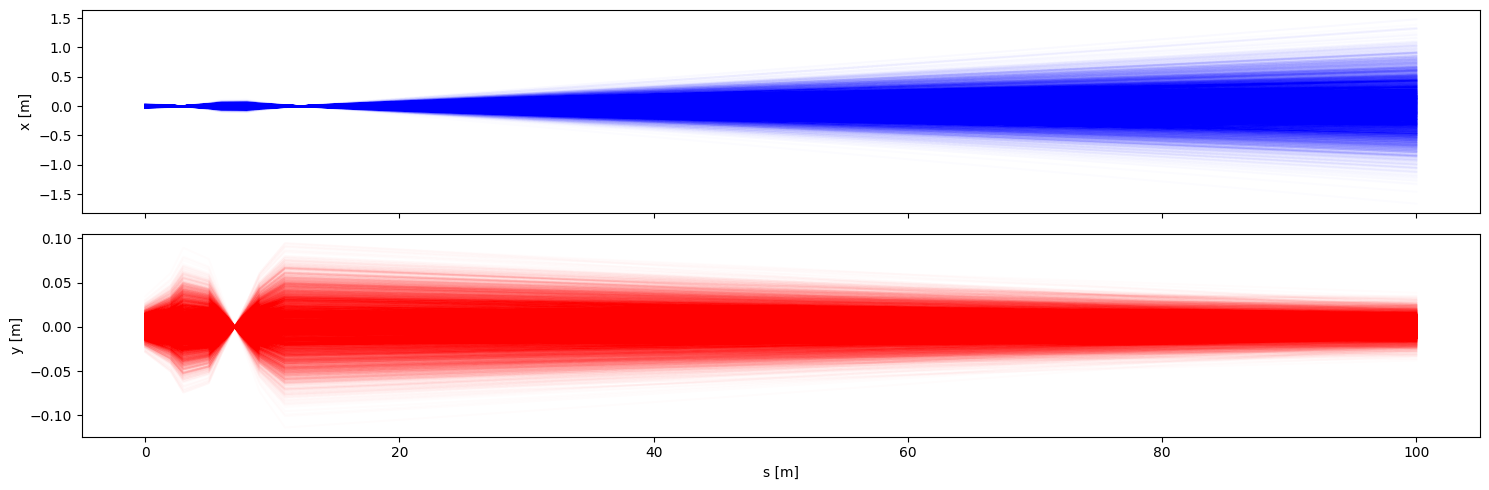

In [8]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax[0].plot(line.record_last_track.s[i], line.record_last_track.x[i], color='blue', alpha=0.01);
    ax[1].plot(line.record_last_track.s[i], line.record_last_track.y[i], color='red', alpha=0.01);

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

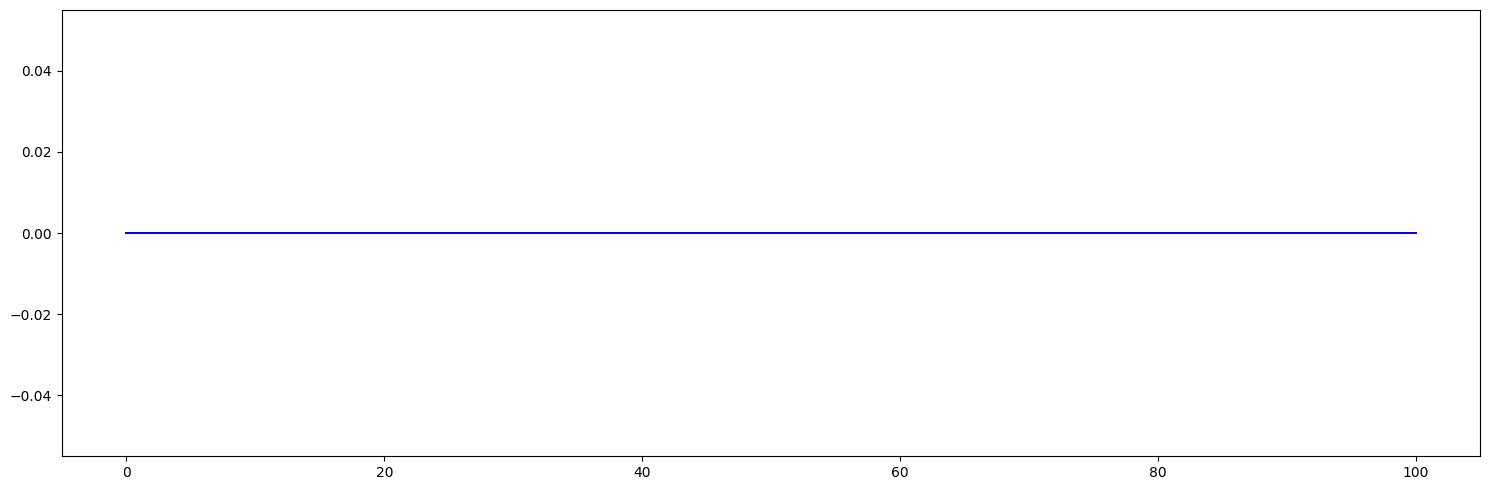

In [7]:
fig,ax = plt.subplots(figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax.plot(line.record_last_track.s[i], line.record_last_track.delta[i], color='blue', alpha=0.01)